In [1]:
from utils import *
import episcanpy.api as epi
import time
import umap

2024-03-02 13:16:55.888516: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-02 13:16:55.910715: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-02 13:16:56.219367: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Read data

In [3]:
file_path = '../data/'
dataset = 'E13_5-S1'
atac = sc.read_h5ad(file_path + dataset + '_atac' + '.h5ad')
atac.X = scipy.sparse.csc_matrix(atac.X)
atac.obs['label'] = atac.obs['Annotation_for_Combined']
 
expr = sc.read_h5ad(file_path + dataset + '_expr' + '.h5ad')
expr.X = scipy.sparse.csc_matrix(expr.X)
expr.obs['label'] = expr.obs['Annotation_for_Combined']
expr.var_names_make_unique()

barcode_set1 = set(atac.obs_names)
barcode_set2 = set(expr.obs_names)

common_barcodes = barcode_set1.intersection(barcode_set2)

atac = atac[atac.obs_names.isin(common_barcodes), :]
expr = expr[expr.obs_names.isin(common_barcodes), :]
expr = expr[atac.obs_names]

sc.pp.normalize_total(expr, target_sum=1e4)
sc.pp.log1p(expr)

count_mat = atac.X.todense().T
tf_mat = 1.0 * count_mat / np.tile(np.sum(count_mat,axis=0), (count_mat.shape[0],1))
ATAC_count = np.log(1 + np.multiply(1e4*tf_mat,  np.tile((1.0 * count_mat.shape[1] / np.sum(count_mat,axis=1)).reshape(-1,1), (1,count_mat.shape[1]))))
atac.X = scipy.sparse.csc_matrix(ATAC_count.T)

atac, expr

(View of AnnData object with n_obs × n_vars = 1777 × 271126
     obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes',

# Run Descartes

In [4]:
save_path = '../result/mouse_brain'
if not os.path.exists(save_path):
    os.makedirs(save_path)
seed_base = 1
tf = None
pc = 10
k = 20
similarity = 'cosine'
iter_time = 4
spmethod = 'threshold'
neighbor = 5
sp_dist = 'recip'
pre_select = 'highest'
peaks_num = 50000
distance = 'euclidean'
r = 0.4

num_select_peak = 20000
idx_atac, _, _, _, _, _,_, _ = run_descartes(atac, num_select_peak, seed_base=seed_base, tfidf=tf, ifPCA=True, pc=pc, k=k, similarity=similarity, iters=iter_time, spmethod=spmethod,neighbor=neighbor,sp_dist=sp_dist, pre_select=pre_select, peaks_num=peaks_num, distance=distance,r=r)

num_select_peak = 2000
idx_expr, _, _, _, _, _,_, _ = run_descartes(expr, num_select_peak, seed_base=seed_base, tfidf=tf, ifPCA=True, pc=pc, k=k, similarity=similarity, iters=iter_time, spmethod=spmethod,neighbor=neighbor,sp_dist=sp_dist, pre_select=pre_select, peaks_num=peaks_num, distance=distance,r=r)

idx_atac.shape, idx_expr.shape

View of AnnData object with n_obs × n_vars = 1777 × 271126
    obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes', '

scores:
[ 1360.11132006  1360.7918667   1361.05247691 ...  9721.80179624
 10502.08018652 16742.92872856]
(1777, 1777)
(1777, 10)
0.0
compute scores


scores:
[ 1360.7924703   1361.05337661  1362.98779098 ...  9723.40960841
 10502.10826597 16742.21451982]
(1777, 1777)
(1777, 10)
0.0
compute scores


scores:
[ 1360.06397625  1360.7896044   1361.17522231 ...  9722.16085053
 10502.56595495 16743.79672805]
(1777, 1777)
(1777, 10)
0.0
compute scores


scores:
[ 1360.06177242  1360.79076807  1361.59935494 ...  9721.97536577
 10501.96821632 16743.95899041]


((20000,), (2000,))

# Gene-peak interaction detection

In [5]:
file_path = '../data/'
dataset = 'E13_5-S1'
atac = sc.read_h5ad(file_path + dataset + '_atac' + '.h5ad')
atac.X = scipy.sparse.csc_matrix(atac.X)
atac.obs['label'] = atac.obs['Annotation_for_Combined']
 
expr = sc.read_h5ad(file_path + dataset + '_expr' + '.h5ad')
expr.X = scipy.sparse.csc_matrix(expr.X)
expr.obs['label'] = expr.obs['Annotation_for_Combined']
expr.var_names_make_unique()

barcode_set1 = set(atac.obs_names)
barcode_set2 = set(expr.obs_names)

common_barcodes = barcode_set1.intersection(barcode_set2)

atac = atac[atac.obs_names.isin(common_barcodes), :]
expr = expr[expr.obs_names.isin(common_barcodes), :]
expr = expr[atac.obs_names]

atac_20000 = atac[:,idx_atac]
expr_2000 = expr[:,idx_expr]
atac_20000,expr_2000

(View of AnnData object with n_obs × n_vars = 1777 × 20000
     obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes', 

In [6]:
sc.pp.normalize_total(expr_2000, target_sum=10000)
sc.pp.log1p(expr_2000)
sc.pp.scale(expr_2000)
expr_2000

AnnData object with n_obs × n_vars = 1777 × 2000
    obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes', 'Gex_MitoRa

In [7]:
count_mat = atac_20000.X.toarray().T
tf_mat = 1.0 * count_mat / np.tile(np.sum(count_mat,axis=0), (count_mat.shape[0],1))
ATAC_count = np.log(1 + np.multiply(1e4*tf_mat,  np.tile((1.0 * count_mat.shape[1] / np.sum(count_mat,axis=1)).reshape(-1,1), (1,count_mat.shape[1]))))
atac_20000.X = scipy.sparse.csc_matrix(ATAC_count.T)
atac_20000

View of AnnData object with n_obs × n_vars = 1777 × 20000
    obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes', 'G

In [8]:
adata = anndata.concat([atac_20000, expr_2000], axis=1)
adata.obs['label'] = list(atac_20000.obs['label'])
adata.obsm['spatial'] = atac_20000.obsm['spatial']
adata

AnnData object with n_obs × n_vars = 1777 × 22000
    obs: 'label'
    obsm: 'spatial'

In [9]:
adata.X = scipy.sparse.csc_matrix(adata.X)

ATAC_count_test = scale(adata.X.toarray())
count = ATAC_count_test.copy()
print(count.shape)
    
similarity_matrix_acb = np.zeros([count.shape[0], count.shape[0]])
similarity_matrix_spatial = np.zeros([count.shape[0], count.shape[0]])

distance_matrix = np.zeros([count.shape[0], count.shape[0]])
print(distance_matrix.shape)

count = PCA(n_components=pc,random_state=int(seed_base*1000)).fit_transform(count)
print(count.shape)
if similarity == 'Jaccard':
    if distance == 'euclidean':
        diff = count[:, np.newaxis, :] - count[np.newaxis, :, :]
        distance_matrix = np.linalg.norm(diff, axis=2)
        np.fill_diagonal(distance_matrix, np.inf)
    elif distance == 'cosine':
        count_norm = np.linalg.norm(count, axis=1, keepdims=True)
        dot_product_matrix = np.dot(count, count.T)
        distance_matrix = 1 - dot_product_matrix / (count_norm * count_norm.T)
        np.fill_diagonal(distance_matrix, np.inf)

distance_matrix_acb = np.copy(distance_matrix)

spatial_data = adata.obsm['spatial']
diff = spatial_data[:, np.newaxis, :] - spatial_data[np.newaxis, :, :]
distance_matrix = np.linalg.norm(diff, axis=2)
np.fill_diagonal(distance_matrix, np.inf)
distance_matrix_spatial = np.copy(distance_matrix)

similarity_matrix_acb = np.zeros([count.shape[0], count.shape[0]])
similarity_matrix_spatial = np.zeros([count.shape[0], count.shape[0]])
if spmethod == 'threshold':
    min_dist = np.min(distance_matrix_spatial)
    if sp_dist == 'const':
        similarity_matrix_spatial = np.array(distance_matrix_spatial <= neighbor * min_dist,dtype=int)
    elif sp_dist == 'recip':
        similarity_matrix_spatial = min_dist / distance_matrix_spatial
        similarity_matrix_spatial = similarity_matrix_spatial * (distance_matrix_spatial <= neighbor * min_dist)
    else:
        similarity_matrix_spatial = (min_dist / distance_matrix_spatial)**2
        similarity_matrix_spatial = similarity_matrix_spatial * (distance_matrix_spatial <= neighbor * min_dist)

elif spmethod == 'SNN':
    neighbor_index = np.argsort(distance_matrix_spatial, axis=1)[:,0:k]
    if similarity == "Jaccard":
        for i in range(count.shape[0]):
            for j in range(i):
                intersect_num = len(np.intersect1d(neighbor_index[i,:], neighbor_index[j,:]))
                similarity_matrix_spatial[i][j] = 1.0*intersect_num/(2*k-intersect_num)
                similarity_matrix_spatial[j][i] = 1.0*intersect_num/(2*k-intersect_num)
if similarity == "Jaccard":
    neighbor_index = np.argsort(distance_matrix_acb, axis=1)[:,0:k]
    for i in range(count.shape[0]):
        for j in range(i):
            intersect_num = len(np.intersect1d(neighbor_index[i,:], neighbor_index[j,:]))
            similarity_matrix_acb[i][j] = 1.0*intersect_num/(2*k-intersect_num)
            similarity_matrix_acb[j][i] = 1.0*intersect_num/(2*k-intersect_num)
elif similarity == "cosine":
    similarity_matrix_acb = sklearn.metrics.pairwise.cosine_similarity(count)
    for i in range(count.shape[0]):
        similarity_matrix_acb[i][i] = -float('inf')
    neighbor_index = np.argsort(similarity_matrix_acb, axis=1)[:,0:(count.shape[0]-k)]
    for i in range(count.shape[0]):
        similarity_matrix_acb[i,neighbor_index[i,:]] = 0
    print(similarity_matrix_acb[0,0])

similarity_matrix = (1 - r) * similarity_matrix_acb + r*similarity_matrix_spatial


print('compute scores')
scores = np.zeros(adata.n_vars)
X_processed = ATAC_count_test

temp_matrix = np.matmul(similarity_matrix, X_processed)
scores = np.sum(X_processed * temp_matrix, axis=0)
sorted_index = np.argsort(scores)
idx = sorted_index[::-1]
print('scores:')
print(scores[idx])

(1777, 22000)
(1777, 1777)
(1777, 10)
0.0
compute scores
scores:
[27063.35616578 24208.65285974 23381.88111058 ...   122.00724002
    68.20435685    64.67631549]


In [10]:
start_time = time.time()
pdist_ = peak_modules_(selected_peaks_data=X_processed, similarity_matrix=similarity_matrix, method='complete')
pdist_ = (pdist_+pdist_.T)/2
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Running time: {elapsed_time:.6f} seconds")
print("Peak modules calculation has been done.")

pdist_.shape

Running time: 14.331252 seconds
Peak modules calculation has been done.


(22000, 22000)

In [11]:
g_p_similarity = pdist_[20000:,:20000]

## The most likely gene and peak

In [12]:
index = np.unravel_index(np.argmax(g_p_similarity, axis=None), g_p_similarity.shape)
index

(1999, 19996)

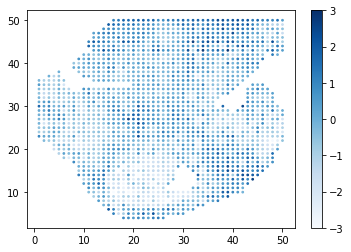

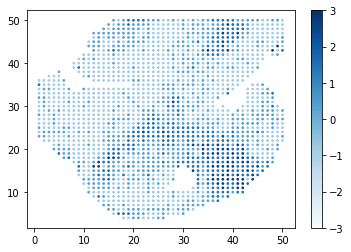

In [13]:
accs = expr_2000.X[:,index[0]]
coord_x = np.array(atac_20000.obsm['spatial'][:,0])
coord_y = np.array(atac_20000.obsm['spatial'][:,1])
accs = np.array(accs)
accs = np.squeeze(accs)
plt.scatter(coord_x, coord_y, c=accs, s=3, cmap='Blues',vmin=-3, vmax=3)
plt.colorbar()
plt.show()

accs = scale(atac_20000.X.toarray())[:,index[1]]
accs = np.array(accs)
accs = np.squeeze(accs)
plt.scatter(coord_x, coord_y, c=accs, s=3, cmap='Blues',vmin=-3, vmax=3)
plt.colorbar()
plt.show()

## Gene to peak

In [14]:
expr_matrix = expr_2000.X
atac_matrix = scale(atac_20000.X.toarray())
expr_matrix.shape, atac_matrix.shape

((1777, 2000), (1777, 20000))

In [15]:
a = anndata.AnnData(scipy.sparse.csc_matrix(atac_matrix))
a.obs_names = list(atac.obs_names)
a.obs['label'] = list(atac.obs['label'])
a.obsm['spatial'] = atac.obsm['spatial']

b = anndata.AnnData(scipy.sparse.csc_matrix(expr_matrix))
b.obs_names = list(expr.obs_names)
b.obs['label'] = list(expr.obs['label'])
b.obsm['spatial'] = expr.obsm['spatial']

result = np.zeros_like(g_p_similarity)
for col in range(g_p_similarity.shape[1]):
    indices = np.argpartition(g_p_similarity[:, col], -20)[-20:]
    result[indices, col] = g_p_similarity[indices, col]
    
    indices = np.argpartition(g_p_similarity[:, col],5)[:5]
    result[indices, col] = g_p_similarity[indices, col]
result.shape

(2000, 20000)

In [16]:
atac_matrix_pred = expr_matrix @ result
atac_matrix_pred = scale(atac_matrix_pred)
atac_matrix_pred.shape

(1777, 20000)

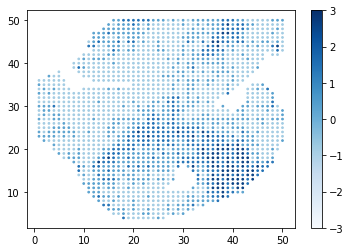

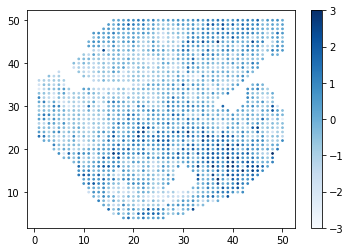

In [17]:
accs = atac_matrix[:,19998]
accs = np.array(accs)
accs = np.squeeze(accs)
plt.scatter(coord_x, coord_y, c=accs, s=3, cmap='Blues',vmin=-3, vmax=3)
plt.colorbar()
plt.show()

accs = atac_matrix_pred[:,19998]
accs = np.array(accs)
accs = np.squeeze(accs)
plt.scatter(coord_x, coord_y, c=accs, s=3, cmap='Blues',vmin=-3, vmax=3)
plt.colorbar()
plt.show()

## Peak to gene

In [18]:
g_p_similarity_T = g_p_similarity.T
result = np.zeros_like(g_p_similarity_T)
for col in range(g_p_similarity_T.shape[1]):
    indices = np.argpartition(g_p_similarity_T[:, col], -20)[-20:]
    result[indices, col] = g_p_similarity_T[indices, col]
    
    indices = np.argpartition(g_p_similarity_T[:, col],5)[:5]
    result[indices, col] = g_p_similarity_T[indices, col]
result.shape

(20000, 2000)

In [19]:
expr_matrix_pred = atac_matrix @ result
expr_matrix_pred = scale(expr_matrix_pred)
expr_matrix_pred.shape

(1777, 2000)

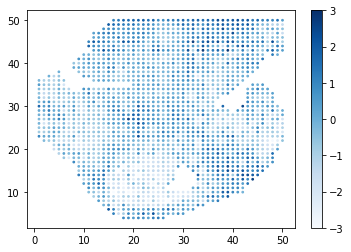

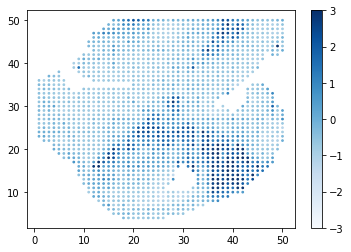

In [20]:
accs = expr_matrix[:,1999]
accs = np.array(accs)
accs = np.squeeze(accs)
plt.scatter(coord_x, coord_y, c=accs, s=3, cmap='Blues',vmin=-3, vmax=3)
plt.colorbar()
plt.show()

accs = expr_matrix_pred[:,1999]
accs = np.array(accs)
accs = np.squeeze(accs)
plt.scatter(coord_x, coord_y, c=accs, s=3, cmap='Blues',vmin=-3, vmax=3)
plt.colorbar()
plt.show()